<a href="https://colab.research.google.com/github/tihunn/emotion_testing/blob/main/emotional_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook with Train emotional tasting

## Import and download database

In [1]:
import numpy as np                                                    # Массивы
import matplotlib.pyplot as plt                                       # Отрисовка графиков
from google.colab import drive                                        # Связь с google диском
import gdown                                                          # Загрузка из google облака
from tensorflow.keras.utils import to_categorical                     # Преобразование категориальных данных в one hot encoding
import os                                                             # Работа с папками и файлами
import shutil
import time                                                           # Утилиты работы со временем
import random                                                         # Работа со случайными числами
import math                                                           # Математические функции
import pickle                                                         # Сохранение и загрузка структур данных Python
import librosa                                                        # Параметризация аудио
from tensorflow.keras.optimizers import Adam, RMSprop                 # Оптимизаторы для обучения моделей
from tensorflow.keras.models import Sequential, Model, load_model     # Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM  # Основные слои
from sklearn.model_selection import train_test_split                  # Разбиение на обучающую и проверочную выборку
from sklearn.preprocessing import LabelEncoder, StandardScaler        # Кодирование категориальных меток, нормирование числовых данных
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Матрица ошибок классификатора
import warnings                                                       # Отключение предупреждений

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Загружаем kaggle.json (вручную загрузите kaggle.json, который вы скачали, через боковое меню "Файлы" в Colab)
!gdown 1Y5WI645-iPqOS55g4wNKsHaWRAWmCQfi
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Устанавливаем kaggle API, если ещё не установлен
!pip install -q kaggle

# Скачиваем набор данных в текущую директорию
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess -p /content/
!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee -p /content/
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio -p /content/

# Разархивируем данные, если они находятся в zip формате
!unzip -q /content/toronto-emotional-speech-set-tess.zip
!unzip -q /content/surrey-audiovisual-expressed-emotion-savee.zip
!mkdir -p /content/ravdess/
!unzip -q /content/ravdess-emotional-speech-audio.zip -d /content/ravdess/
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path)
# Удаляем zip-архивы, если они больше не нужны
!rm -r /content/toronto-emotional-speech-set-tess.zip /content/sample_data \
"/content/tess toronto emotional speech set data" kaggle.json \
/content/surrey-audiovisual-expressed-emotion-savee.zip \
/content/ravdess-emotional-speech-audio.zip


Downloading...
From: https://drive.google.com/uc?id=1Y5WI645-iPqOS55g4wNKsHaWRAWmCQfi
To: /content/kaggle.json
100% 67.0/67.0 [00:00<00:00, 252kB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 426M/428M [00:02<00:00, 209MB/s]
100% 428M/428M [00:02<00:00, 164MB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee
License(s): copyright-authors
 99% 106M/107M [00:00<00:00, 138MB/s] 
100% 107M/107M [00:00<00:00, 137MB/s]
Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 97% 416M/429M [00:03<00:00, 135MB/s]
100% 429M/429M [00:03<00:00, 135MB/s]


100%|██████████| 429M/429M [00:06<00:00, 69.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1


## упорядочивание папок

In [3]:
def count_files_in_directory(path, depth=0):
    # Получаем содержимое директории
    try:
        entries = os.listdir(path)
    except FileNotFoundError:
        print("Указанная папка не найдена.")
        return

    # Списки для файлов и поддиректорий
    files = []
    directories = []

    # Разделение файлов и папок в текущей директории
    for entry in entries:
        full_path = os.path.join(path, entry)
        if os.path.isfile(full_path):
            files.append(full_path)
        elif os.path.isdir(full_path):
            directories.append(full_path)

    # Подсчет и вывод форматов файлов
    if files:
        formats = {os.path.splitext(file)[1][1:].lower() for file in files}
        indent = ' ' * (2 * depth)
        print(f"{indent}Папка '{os.path.basename(path)}': {len(files)} файлов, форматы: {', '.join(formats)}")
    else:
        print(f"{' ' * (2 * depth)}Папка '{os.path.basename(path)}' пуста.")

    # Рекурсивно обходим поддиректории с увеличением отступа
    for directory in directories:
        count_files_in_directory(directory, depth + 1)


count_files_in_directory("/content/TESS Toronto emotional speech set data")

Папка 'TESS Toronto emotional speech set data' пуста.
  Папка 'OAF_neutral': 200 файлов, форматы: wav
  Папка 'YAF_sad': 200 файлов, форматы: wav
  Папка 'YAF_neutral': 200 файлов, форматы: wav
  Папка 'OAF_disgust': 200 файлов, форматы: wav
  Папка 'OAF_Pleasant_surprise': 200 файлов, форматы: wav
  Папка 'OAF_Fear': 200 файлов, форматы: wav
  Папка 'YAF_fear': 200 файлов, форматы: wav
  Папка 'YAF_disgust': 200 файлов, форматы: wav
  Папка 'YAF_angry': 200 файлов, форматы: wav
  Папка 'YAF_pleasant_surprised': 200 файлов, форматы: wav
  Папка 'YAF_happy': 200 файлов, форматы: wav
  Папка 'OAF_happy': 200 файлов, форматы: wav
  Папка 'OAF_angry': 200 файлов, форматы: wav
  Папка 'OAF_Sad': 200 файлов, форматы: wav


In [4]:
def reorganize_folders(base_path):
    # Список для хранения названий созданных папок
    created_folders = []

    # Получаем список всех папок в указанной директории
    for folder_name in os.listdir(base_path):
        # Полный путь к текущей папке
        folder_path = os.path.join(base_path, folder_name)

        # Проверяем, является ли элемент папкой и имеет ли разделитель '_'
        if os.path.isdir(folder_path) and '_' in folder_name:
            # Получаем "последнее слово" после разделителя '_'
            target_folder_name = folder_name.split('_')[-1].lower()
            target_folder_path = os.path.join(base_path, target_folder_name)

            # Обработка специального случая
            if folder_name == 'YAF_pleasant_surprised':
                target_folder_name = 'surprise'
                target_folder_path = os.path.join(base_path, target_folder_name)

            # Создаем папку назначения, если она не существует
            if target_folder_name not in created_folders:
                os.makedirs(target_folder_path, exist_ok=True)
                created_folders.append(target_folder_name)

            # Перемещаем все файлы из текущей папки в папку назначения
            for file_name in os.listdir(folder_path):
                source_file_path = os.path.join(folder_path, file_name)

                # Проверяем, что это файл, а не вложенная папка
                if os.path.isfile(source_file_path):
                    shutil.move(source_file_path, target_folder_path)

            # Удаляем пустую исходную папку
            os.rmdir(folder_path)

    # Возвращаем список созданных папок
    return created_folders

# Пример вызова функции
created_folders = reorganize_folders("/content/TESS Toronto emotional speech set data")
print("Созданные папки:", created_folders)


Созданные папки: ['neutral', 'sad', 'disgust', 'surprise', 'fear', 'angry', 'happy']


In [5]:
count_files_in_directory("/content/TESS Toronto emotional speech set data")

Папка 'TESS Toronto emotional speech set data' пуста.
  Папка 'sad': 400 файлов, форматы: wav
  Папка 'happy': 400 файлов, форматы: wav
  Папка 'neutral': 400 файлов, форматы: wav
  Папка 'disgust': 400 файлов, форматы: wav
  Папка 'surprise': 400 файлов, форматы: wav
  Папка 'fear': 400 файлов, форматы: wav
  Папка 'angry': 400 файлов, форматы: wav


In [6]:
import os
import shutil

def distribute_ravdess_files(source_folder, target_folder):
    # Соответствие номеров классов и их названий
    class_map = {
        '01': 'neutral',
        '02': 'neutral',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fear',
        '07': 'disgust',
        '08': 'surprise'
    }

    # Создаем целевые папки для каждого класса, если они еще не созданы
    for class_name in class_map.values():
        os.makedirs(os.path.join(target_folder, class_name), exist_ok=True)

    # Рекурсивно проходим по всем файлам и подкаталогам в исходной папке
    for root, _, files in os.walk(source_folder):
        for file_name in files:
            # Проверяем, является ли файл аудиофайлом в нужном формате
            if file_name.endswith('.wav'):
                # Извлекаем класс из названия файла
                class_number = file_name.split('-')[2]

                # Если класс присутствует в class_map, перемещаем файл
                if class_number in class_map:
                    class_name = class_map[class_number]
                    target_class_folder = os.path.join(target_folder, class_name)

                    # Полные пути к исходному и целевому файлам
                    source_file_path = os.path.join(root, file_name)
                    target_file_path = os.path.join(target_class_folder, file_name)

                    # Перемещаем файл в соответствующую папку
                    shutil.move(source_file_path, target_file_path)
                    print(f"Файл {file_name} перемещен в {target_class_folder}")



distribute_ravdess_files('/content/ravdess', '/content/ravdess1')


Файл 03-01-05-02-02-02-09.wav перемещен в /content/ravdess1/angry
Файл 03-01-02-02-02-01-09.wav перемещен в /content/ravdess1/neutral
Файл 03-01-08-02-01-02-09.wav перемещен в /content/ravdess1/surprise
Файл 03-01-06-02-01-01-09.wav перемещен в /content/ravdess1/fear
Файл 03-01-07-01-01-01-09.wav перемещен в /content/ravdess1/disgust
Файл 03-01-04-01-02-02-09.wav перемещен в /content/ravdess1/sad
Файл 03-01-07-01-01-02-09.wav перемещен в /content/ravdess1/disgust
Файл 03-01-08-02-02-02-09.wav перемещен в /content/ravdess1/surprise
Файл 03-01-04-02-01-02-09.wav перемещен в /content/ravdess1/sad
Файл 03-01-07-02-02-02-09.wav перемещен в /content/ravdess1/disgust
Файл 03-01-03-02-02-01-09.wav перемещен в /content/ravdess1/happy
Файл 03-01-04-02-01-01-09.wav перемещен в /content/ravdess1/sad
Файл 03-01-06-01-02-02-09.wav перемещен в /content/ravdess1/fear
Файл 03-01-03-01-02-01-09.wav перемещен в /content/ravdess1/happy
Файл 03-01-01-01-01-01-09.wav перемещен в /content/ravdess1/neutral
Фа

In [7]:
count_files_in_directory("/content/TESS Toronto emotional speech set data")

Папка 'TESS Toronto emotional speech set data' пуста.
  Папка 'sad': 400 файлов, форматы: wav
  Папка 'happy': 400 файлов, форматы: wav
  Папка 'neutral': 400 файлов, форматы: wav
  Папка 'disgust': 400 файлов, форматы: wav
  Папка 'surprise': 400 файлов, форматы: wav
  Папка 'fear': 400 файлов, форматы: wav
  Папка 'angry': 400 файлов, форматы: wav


In [8]:
import os
import shutil

def organize_audio_files(source_folder, dataset_folder='data'):
    # Название папок и соответствие сокращений классов
    class_map = {
        'n': 'neutral',
        'd': 'disgust',
        'sa': 'sad',
        'h': 'happy',
        'su': 'surprise',
        'a': 'angry',
        'f': 'fear'
    }

    # Создаем основную папку набора данных и подкатегории
    os.makedirs(dataset_folder, exist_ok=True)
    for class_name in class_map.values():
        os.makedirs(os.path.join(dataset_folder, class_name), exist_ok=True)

    # Перебираем все файлы в исходной папке
    for file_name in os.listdir(source_folder):
        # Проверяем, что это файл и он имеет формат .wav
        file_path = os.path.join(source_folder, file_name)
        if os.path.isfile(file_path) and file_name.endswith('.wav'):
            # Извлекаем часть после символа "_"
            parts = file_name.split('_')
            if len(parts) < 2:
                continue  # Пропускаем файл, если он не соответствует формату

            # Класс - часть после "_"
            class_code = parts[1][0:2]  # Пробуем извлечь первые две буквы после "_"

            # Проверяем, есть ли такой класс в class_map, иначе проверяем первую букву
            if class_code not in class_map:
                class_code = class_code[0]  # Сокращаем до одной буквы, если двухбуквенный код не найден

            # Если класс найден в class_map, перемещаем файл в нужную папку
            if class_code in class_map:
                target_folder = os.path.join(dataset_folder, class_map[class_code])
                shutil.move(file_path, os.path.join(target_folder, file_name))
                # print(f"Файл {file_name} перемещен в {target_folder}")
            else:
                print(f"Класс не распознан для файла {file_name}")

# Пример вызова функции
organize_audio_files('/content/ALL', "/content/SAVEE")


In [9]:
count_files_in_directory("/content/SAVEE")

Папка 'SAVEE' пуста.
  Папка 'sad': 60 файлов, форматы: wav
  Папка 'happy': 60 файлов, форматы: wav
  Папка 'neutral': 120 файлов, форматы: wav
  Папка 'disgust': 60 файлов, форматы: wav
  Папка 'surprise': 60 файлов, форматы: wav
  Папка 'fear': 60 файлов, форматы: wav
  Папка 'angry': 60 файлов, форматы: wav


In [10]:
# prompt: write code for remove half data in /content/SAVEE/neutral

import os
import random

def remove_half_data(directory, num_need):
    """Removes half of the files in a directory at random."""
    try:
        files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
        num_files_to_remove = len(files) - num_need
        files_to_remove = random.sample(files, num_files_to_remove)

        for file in files_to_remove:
            file_path = os.path.join(directory, file)
            os.remove(file_path)
            # print(f"Removed: {file_path}")
        print(f"Removed {num_files_to_remove} files from {directory}")
    except FileNotFoundError:
        print(f"Error: Directory '{directory}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage:
remove_half_data('/content/SAVEE/neutral', 60)

Removed 60 files from /content/SAVEE/neutral


In [11]:
# prompt: перемести содержимое каждой папки из /content/SAVEE в соответствующую папку в /content/TESS Toronto emotional speech set data

import shutil
import os

def move_folder_contents(source_dir, destination_dir):
  """Moves the contents of subfolders within a source directory to corresponding subfolders in a destination directory."""
  for folder_name in os.listdir(source_dir):
    source_folder_path = os.path.join(source_dir, folder_name)
    destination_folder_path = os.path.join(destination_dir, folder_name)

    if os.path.isdir(source_folder_path):
      # Create the destination folder if it doesn't exist
      os.makedirs(destination_folder_path, exist_ok=True)

      for item_name in os.listdir(source_folder_path):
        source_item_path = os.path.join(source_folder_path, item_name)
        destination_item_path = os.path.join(destination_folder_path, item_name)

        if os.path.isfile(source_item_path):
          shutil.move(source_item_path, destination_item_path)
          # print(f"Moved '{item_name}' from '{source_folder_path}' to '{destination_folder_path}'")


# Example usage
move_folder_contents("/content/SAVEE", "/content/TESS Toronto emotional speech set data")

In [12]:
# prompt: перемести все папки и файлы из этой /content/SAVEE папки в эту /content/TESS Toronto emotional speech set data

import shutil

def move_files_and_folders(source_path, destination_path):
    """Moves all files and folders from the source to the destination."""
    try:
        for item in os.listdir(source_path):
            source_item_path = os.path.join(source_path, item)
            destination_item_path = os.path.join(destination_path, item)

            if os.path.isfile(source_item_path):
                shutil.move(source_item_path, destination_item_path)
                print(f"Moved file: {item}")
    except FileNotFoundError:
        print(f"Error: Source path '{source_path}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
move_files_and_folders("/content/SAVEE", "/content/TESS Toronto emotional speech set data")

In [13]:
count_files_in_directory("/content/SAVEE")
count_files_in_directory("/content/TESS Toronto emotional speech set data")

Папка 'SAVEE' пуста.
  Папка 'sad' пуста.
  Папка 'happy' пуста.
  Папка 'neutral' пуста.
  Папка 'disgust' пуста.
  Папка 'surprise' пуста.
  Папка 'fear' пуста.
  Папка 'angry' пуста.
Папка 'TESS Toronto emotional speech set data' пуста.
  Папка 'sad': 460 файлов, форматы: wav
  Папка 'happy': 460 файлов, форматы: wav
  Папка 'neutral': 460 файлов, форматы: wav
  Папка 'disgust': 460 файлов, форматы: wav
  Папка 'surprise': 460 файлов, форматы: wav
  Папка 'fear': 460 файлов, форматы: wav
  Папка 'angry': 460 файлов, форматы: wav


## Определение оптимальной продолжительности

In [14]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

def analyze_audio_files(base_path):
    stats = {}

    # Проход по каждой папке в базе данных
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)

        if os.path.isdir(folder_path):
            # Инициализируем вложенный словарь для папки
            stats[folder_name] = {
                "duration": [],
                "silence": [],
                "some_feature": []  # Пример: можно добавить более специфическую характеристику
            }

            # Проход по каждому файлу в папке
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)

                if os.path.isfile(file_path) and file_path.endswith('.wav'):
                    # Загружаем аудиофайл
                    y, sr = librosa.load(file_path)

                    # Анализ продолжительности
                    duration = librosa.get_duration(y=y, sr=sr)
                    stats[folder_name]["duration"].append(duration)

                    # Анализ тишины: ищем сегменты ниже порога амплитуды (например, -40 дБ)
                    silence_threshold = 0.01
                    silence_frames = librosa.effects.split(y, top_db=40)
                    silence_feature = np.zeros(len(y), dtype=int)
                    for start, end in silence_frames:
                        silence_feature[start:end] = 1
                    stats[folder_name]["silence"].append(silence_feature)

                    # Добавление другой характеристики (пример: RMS энергии)
                    rms = librosa.feature.rms(y=y)[0]
                    stats[folder_name]["some_feature"].append(rms)

    return stats

def plot_statistics(stats):
    for folder_name, data in stats.items():
        # Показ данных по продолжительности и тишине
        plt.figure(figsize=(10, 6))

        # График продолжительности
        plt.subplot(2, 2, 1)
        plt.bar(range(len(data["duration"])), data["duration"], color='skyblue')
        plt.title(f"Продолжительность файлов в {folder_name}")
        plt.xlabel("Файл")
        plt.ylabel("Продолжительность (сек)")

        # График тишины
        plt.subplot(2, 2, 2)
        silence_averages = [np.mean(s) for s in data["silence"]]
        plt.bar(range(len(silence_averages)), silence_averages, color='salmon')
        plt.title(f"Уровень тишины в {folder_name}")
        plt.xlabel("Файл")
        plt.ylabel("Средняя тишина")

        # График характеристики (например, RMS энергии)
        plt.subplot(2, 2, 3)
        avg_feature = [np.mean(f) for f in data["some_feature"]]
        plt.bar(range(len(avg_feature)), avg_feature, color='lightgreen')
        plt.title(f"Характеристика (RMS) в {folder_name}")
        plt.xlabel("Файл")
        plt.ylabel("Среднее RMS значение")

        plt.tight_layout()
        plt.show()

    # Сводный график для всех файлов всех папок
    all_durations = [dur for folder_data in stats.values() for dur in folder_data["duration"]]
    all_silences = [np.mean(s) for folder_data in stats.values() for s in folder_data["silence"]]
    all_features = [np.mean(f) for folder_data in stats.values() for f in folder_data["some_feature"]]

    plt.figure(figsize=(10, 6))

    # График всех продолжительностей
    plt.subplot(3, 1, 1)
    plt.bar(range(len(all_durations)), all_durations, color='skyblue')
    plt.title("Сводный график продолжительности")
    plt.xlabel("Файл")
    plt.ylabel("Продолжительность (сек)")

    # График всех средних уровней тишины
    plt.subplot(3, 1, 2)
    plt.bar(range(len(all_silences)), all_silences, color='salmon')
    plt.title("Сводный график средней тишины")
    plt.xlabel("Файл")
    plt.ylabel("Средняя тишина")

    # График всех характеристик (RMS энергии)
    plt.subplot(3, 1, 3)
    plt.bar(range(len(all_features)), all_features, color='lightgreen')
    plt.title("Сводный график средней характеристики (RMS)")
    plt.xlabel("Файл")
    plt.ylabel("Среднее RMS значение")

    plt.tight_layout()
    plt.show()

# Пример вызова функций
base_path = "/content/TESS Toronto emotional speech set data"
stats = analyze_audio_files(base_path)
plot_statistics(stats)


KeyboardInterrupt: 

## стандартизация продолжительности

In [14]:
import os
import librosa
import soundfile as sf
import numpy as np

def normalise_duration(input_file_path, output_folder_path, target_duration=2.0):
    # Загружаем аудиофайл
    y, sr = librosa.load(input_file_path)

    # Определяем текущую продолжительность файла
    current_duration = librosa.get_duration(y=y, sr=sr)

    # Проверяем, нужно ли растягивать или обрезать
    if current_duration >= target_duration:
        # Если файл длиннее 2 секунд, обрезаем его
        y_processed = y[:int(target_duration * sr)]
        print(f"Файл '{os.path.basename(input_file_path)}' обрезан до 2 секунд.")
    else:
        # Если файл короче 2 секунд, вычисляем недостающую длину и повторяем его
        repeats = int(np.ceil(target_duration / current_duration))  # Количество повторений
        y_stretched = np.tile(y, repeats)  # Повторение сигнала

        # Обрезаем до точно 2 секунд
        y_processed = y_stretched[:int(target_duration * sr)]
        print(f"Файл '{os.path.basename(input_file_path)}' удлинен до 2 секунд.")

    # Генерируем путь для сохранения нового файла
    output_file_path = os.path.join(output_folder_path, os.path.basename(input_file_path))

    # Сохраняем обработанный файл
    sf.write(output_file_path, y_processed, sr)
    print(f"Файл '{os.path.basename(input_file_path)}' сохранен в '{output_file_path}'.")

normalise_duration("/content/TESS Toronto emotional speech set data/fear/OAF_back_fear.wav", \
                           "/content/", target_duration=2)

Файл 'OAF_back_fear.wav' удлинен до 2 секунд.
Файл 'OAF_back_fear.wav' сохранен в '/content/OAF_back_fear.wav'.


In [15]:
def create_norm_duration_dataset(input_folder_path, output_folder_path):
    # Убедимся, что корневая папка для сохранения нового набора данных существует
    os.makedirs(output_folder_path, exist_ok=True)

    # Рекурсивный обход папок и файлов в исходной директории
    for root, dirs, files in os.walk(input_folder_path):
        # Создаем эквивалентную директорию в папке назначения
        relative_path = os.path.relpath(root, input_folder_path)
        output_dir = os.path.join(output_folder_path, relative_path)
        os.makedirs(output_dir, exist_ok=True)

        # Проходим по каждому файлу в текущей директории
        for file_name in files:
            # Проверяем, что это аудиофайл формата .wav
            if file_name.endswith('.wav'):
                input_file_path = os.path.join(root, file_name)

                # Применяем функцию stretch_audio_to_2_seconds для обработки файла
                normalise_duration(input_file_path, output_dir)
                print(f"Файл '{file_name}' обработан и сохранен в '{output_dir}'.")


create_norm_duration_dataset("TESS Toronto emotional speech set data", "TESS2")
create_norm_duration_dataset("ravdess1", "ravdess2")

Streaming output truncated to the last 5000 lines.
Файл 'YAF_late_angry.wav' сохранен в 'TESS2/angry/YAF_late_angry.wav'.
Файл 'YAF_late_angry.wav' обработан и сохранен в 'TESS2/angry'.
Файл 'OAF_tough_angry.wav' удлинен до 2 секунд.
Файл 'OAF_tough_angry.wav' сохранен в 'TESS2/angry/OAF_tough_angry.wav'.
Файл 'OAF_tough_angry.wav' обработан и сохранен в 'TESS2/angry'.
Файл 'OAF_judge_angry.wav' удлинен до 2 секунд.
Файл 'OAF_judge_angry.wav' сохранен в 'TESS2/angry/OAF_judge_angry.wav'.
Файл 'OAF_judge_angry.wav' обработан и сохранен в 'TESS2/angry'.
Файл 'OAF_wag_angry.wav' удлинен до 2 секунд.
Файл 'OAF_wag_angry.wav' сохранен в 'TESS2/angry/OAF_wag_angry.wav'.
Файл 'OAF_wag_angry.wav' обработан и сохранен в 'TESS2/angry'.
Файл 'OAF_loaf_angry.wav' удлинен до 2 секунд.
Файл 'OAF_loaf_angry.wav' сохранен в 'TESS2/angry/OAF_loaf_angry.wav'.
Файл 'OAF_loaf_angry.wav' обработан и сохранен в 'TESS2/angry'.
Файл 'YAF_shout_angry.wav' обрезан до 2 секунд.
Файл 'YAF_shout_angry.wav' сохране

In [16]:
count_files_in_directory("/content/TESS2")
count_files_in_directory('/content/ravdess2')

Папка 'TESS2' пуста.
  Папка 'sad': 460 файлов, форматы: wav
  Папка 'happy': 460 файлов, форматы: wav
  Папка 'neutral': 460 файлов, форматы: wav
  Папка 'disgust': 460 файлов, форматы: wav
  Папка 'surprise': 460 файлов, форматы: wav
  Папка 'fear': 460 файлов, форматы: wav
  Папка 'angry': 460 файлов, форматы: wav
Папка 'ravdess2' пуста.
  Папка 'sad': 192 файлов, форматы: wav
  Папка 'happy': 192 файлов, форматы: wav
  Папка 'neutral': 288 файлов, форматы: wav
  Папка 'disgust': 192 файлов, форматы: wav
  Папка 'surprise': 192 файлов, форматы: wav
  Папка 'fear': 192 файлов, форматы: wav
  Папка 'angry': 192 файлов, форматы: wav


## Создание обучающего набора (вариант от гпт)

In [18]:
import os
import numpy as np
import librosa

def preprocess_audio_to_melspectrogram(file_path, sr=22050, n_mels=40, n_fft=2048, hop_length=512):
    # Загружаем аудиофайл
    y, _ = librosa.load(file_path, sr=sr)

    # Получаем мел-спектрограмму
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

    # Преобразуем мел-спектрограмму в логарифмическую шкалу для улучшения видимости признаков
    log_melspectrogram = librosa.power_to_db(melspectrogram)

    return log_melspectrogram.T  # Транспонируем, чтобы иметь форму (time_steps, mel_features)

# Пример обработки всего набора данных
def load_dataset(data_folder, sr=22050, n_mels=40, n_fft=2048, hop_length=512):
    x_data = []
    y_data = []
    class_labels = sorted(os.listdir(data_folder))  # Сортируем классы для согласованного кодирования
    label_map = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        class_folder = os.path.join(data_folder, label)
        for file_name in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file_name)
            if file_name.endswith('.wav'):
                # Генерируем мел-спектрограмму для каждого файла
                melspectrogram = preprocess_audio_to_melspectrogram(file_path, sr, n_mels, n_fft, hop_length)
                x_data.append(melspectrogram)
                y_data.append(label_map[label])

    # Преобразуем списки в numpy массивы
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    return x_data, y_data, label_map


# Укажите путь к папке с данными
data_folder = '/content/TESS2'
x_train_data, y_train_data, label_map = load_dataset(data_folder)
x_val_data, y_val_data, label_map_val = load_dataset('/content/ravdess2')
# Размеры данных будут (samples, time_steps, mel_features)
# Например, (количество файлов, ~130 временных шагов, 40 мел-фильтров)
print(x_train_data.shape)
print(x_val_data.shape)

(3220, 87, 40)
(1440, 87, 40)


## Создание обучающего набора

In [18]:
# Установка констант
FILE_DIR = "/content/"                    # Папка с файлами датасета
CLASS_LIST = created_folders              # Список классов, порядок меток не определен!
                                          # порядок словаря сохраняется, я спрашивал у gpt, это с 3.7 версии пайтона, иначе нужно было бы юзать отдельную встроеную функцию
CLASS_COUNT = len(CLASS_LIST)             # Количество классов
CLASS_FILES = 400                         # Общее количество файлов в каждом классе (вручную len писал было 400)
FILE_INDEX_TRAIN_SPLIT = 400              # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.15                   # Доля проверочной выборки в основном наборе
DURATION_SEC = 30                         # Анализируемая длительность аудиосигнала (звуки очень короткие ниже написал функцию для опеределения самой короткой)
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков

# Функция параметризации аудио
def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 n_fft=N_FFT,           # размер скользящего окна БПФ
                 hop_length=HOP_LENGTH  # шаг скользящего окна БПФ
                 ):
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)     # Хромаграмма
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)                   # Мел-кепстральные коэффициенты
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)                                        # Среднеквадратическая амплитуда
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length) # Спектральный центроид
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)  # Ширина полосы частот
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)    # Спектральный спад частоты
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)                            # Пересечения нуля

    # Сборка признаков в общий список:
    features = {'rmse': rmse,
                'spct': spec_cent,
                'spbw': spec_bw,
                'roff': rolloff,
                'zcr' : zcr,
                'mfcc': mfcc,
                'stft': chroma_stft}

    return features

# Функция формирования набора признаков и метки класса для аудиофайла
def get_feature_list_from_file(class_index,  # индекс класса файла song_name
                               song_name,    # имя аудиофайла
                               duration_sec  # длительность аудио в секундах
                               ):
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec) # Загрузка в 'y' первых duration_sec секунд аудиосигнала
    feat = get_features(y, sr)                                        # Извлечение параметров из аудиосигнала

    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v
    feature_set = features.T                                          # формирования набора признаков

    y_label = to_categorical(class_index, CLASS_COUNT)                # Перевод номера класса в one hot encoding

    return feature_set, y_label

# Функция формирования подвыборки признаков и меток класса для одного файла
def create_train_data(database_path, # path for data base
                 duration_sec=1,  # длительность аудио в секундах
                 ):
    curr_time = time.time() # Фиксация времени старта формирования выборки
    # class_name = CLASS_LIST[class_index]
    x_data = None # Списки для последовательностей входных данных и меток класса
    y_data = None

    # Проходим по всем папкам в указанной директории
    for folder_of_class in os.listdir(database_path):
        # Полный путь к текущей папке
        folder_path_of_class = os.path.join(database_path, folder_of_class)

        # Проверяем, что это папка
        if os.path.isdir(folder_path_of_class):
            # Проверяем, есть ли папка в списке created_folders и получаем её индекс
            if folder_of_class in created_folders:
                class_index = created_folders.index(folder_of_class)

                # Перебираем файлы в текущей папке
                for file_name in os.listdir(folder_path_of_class):
                    x_list = [] # список для составления всех фич к одному файлу
                    y_list = [] # hoe этого класса
                    file_path = os.path.join(folder_path_of_class, file_name)
                    feature_set, y_label = get_feature_list_from_file(class_index, file_path, duration_sec) # Выборка признаков и метки класса для произведения
                    for j in range(feature_set.shape[0]): # Добавление данных в наборы
                        x_list.append(feature_set[j])
                        y_list.append(y_label)
                    x_data = x_list if x_data is None else np.vstack([x_data, x_list])
                    y_data = y_list if y_data is None else np.vstack([y_data, y_list])

                print(f'Эмоция {CLASS_LIST[class_index]} готова -> {round(time.time() - curr_time)} c')  # Вывод информации о готовности обработки датасета
                curr_time = time.time()
            else:
                print(f"Папка '{folder_of_class}' не найдена в списке created_folders.")  # ну тип обработка ошибки на всякий

    return x_data, y_data

# Формирование тренировочного (основного) набора данных
x_train_data, y_train_data = create_train_data("/content/TESS2", duration_sec=2)
x_val_data, y_val_data = create_train_data("/content/ravdess2", duration_sec=2)

Эмоция sad готова -> 74 c
Эмоция happy готова -> 72 c
Эмоция neutral готова -> 74 c
Эмоция disgust готова -> 80 c
Эмоция surprise готова -> 77 c
Эмоция fear готова -> 80 c
Эмоция angry готова -> 83 c
Эмоция sad готова -> 29 c
Эмоция happy готова -> 31 c
Эмоция neutral готова -> 44 c
Эмоция disgust готова -> 30 c
Эмоция surprise готова -> 30 c
Эмоция fear готова -> 30 c
Эмоция angry готова -> 31 c


## Сохранение и загрузка наборов

In [19]:
# prompt: сохрани на гугл диск x_train_data, y_train_data, x_val_data, y_val_data

import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path where you want to save the data on Google Drive
save_path = '/content/drive/MyDrive/audio_emotion_recognition_data'  # Change to your desired location

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)


# Save the NumPy arrays to files in the specified directory
np.save(os.path.join(save_path, 'x_train_data.npy'), x_train_data)
np.save(os.path.join(save_path, 'y_train_data.npy'), y_train_data)
np.save(os.path.join(save_path, 'x_val_data.npy'), x_val_data)
np.save(os.path.join(save_path, 'y_val_data.npy'), y_val_data)

print("Data saved to Google Drive:", save_path)

Mounted at /content/drive
Data saved to Google Drive: /content/drive/MyDrive/audio_emotion_recognition_data


In [20]:
# prompt: напиши код для чтения вышесозданых файлов в переменные

import numpy as np
import os

# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Define the path where the data is saved on Google Drive
save_path = '/content/drive/MyDrive/audio_emotion_recognition_data'

# Load the NumPy arrays from the files
try:
  x_train_data = np.load(os.path.join(save_path, 'x_train_data.npy'))
  y_train_data = np.load(os.path.join(save_path, 'y_train_data.npy'))
  x_val_data = np.load(os.path.join(save_path, 'x_val_data.npy'))
  y_val_data = np.load(os.path.join(save_path, 'y_val_data.npy'))

  print("Data loaded successfully from Google Drive.")

except FileNotFoundError:
  print(f"Error: Data files not found at {save_path}.")
except Exception as e:
  print(f"An error occurred while loading data: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully from Google Drive.


## создание выборок

In [22]:
from tensorflow.keras.utils import to_categorical
num_classes = 7
# Преобразуем метки в one-hot encoding
y_train_data = to_categorical(y_train_data, num_classes=num_classes)
y_val_data = to_categorical(y_val_data, num_classes=num_classes)


In [23]:
y_train_data.shape

(3220, 7)

## архитектура модели

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Attention, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_emotion_recognition_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    # Convolutional layers for feature extraction
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # LSTM layer for temporal dependencies
    lstm_out = LSTM(128, return_sequences=True)(x)

    # Attention mechanism
    attention = Attention()([lstm_out, lstm_out])  # Self-attention
    x = GlobalAveragePooling1D()(attention)  # Reduce to 1D by averaging over time dimension

    # Fully connected layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs)
    return model



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 87, 40)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 87, 64)         │          7,744 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 87, 64)         │            256 │ conv1d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 87, 64)         │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 87, 128)        │         24,704 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 87, 128)        │            512 │ conv1d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 87, 128)        │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 87, 256)        │         98,560 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 87, 256)        │          1,024 │ conv1d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 87, 128)        │        197,120 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_2 (Attention)   │ (None, 87, 128)        │              0 │ lstm_2[0][0],          │
│                           │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ attention_2[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │         16,512 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 128)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 64)             │          8,256 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 64)             │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)      

 Total params: 355,143 (1.35 MB)

 Trainable params: 354,247 (1.35 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.2452 - loss: 1.8673 - val_accuracy: 0.1667 - val_loss: 1.9235
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5293 - loss: 1.3470 - val_accuracy: 0.2389 - val_loss: 1.8866
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7291 - loss: 0.8297 - val_accuracy: 0.2375 - val_loss: 2.0591
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8253 - loss: 0.5493 - val_accuracy: 0.1965 - val_loss: 2.2740
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8649 - loss: 0.3891 - val_accuracy: 0.1868 - val_loss: 2.6220
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8865 - loss: 0.3163 - val_accuracy: 0.2028 - val_loss: 2.5037
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9004 - loss: 0.2970 - val_accuracy: 0.1688 - val_loss: 2.5627


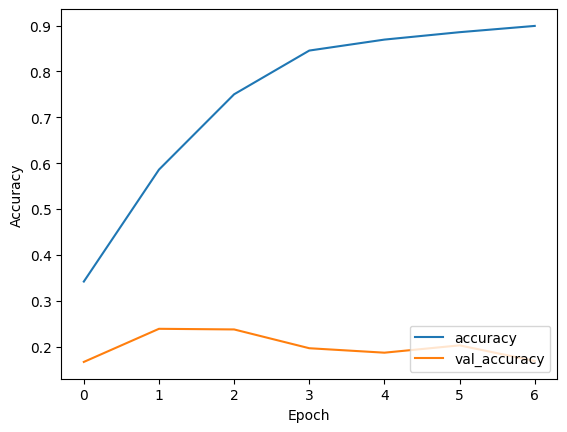

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Пример использования
input_shape = (x_train_data.shape[1], x_train_data.shape[2])
num_classes = 7  # Number of classes

# Определение callback-функций
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_attention.keras', monitor='val_accuracy', save_best_only=True)

# Компиляция модели

model = create_emotion_recognition_model(input_shape, num_classes)
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(x_train_data, y_train_data, epochs=30, batch_size=32,
                    validation_data=(x_val_data, y_val_data),
                    callbacks=[early_stopping, model_checkpoint])

# График истории обучения
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [ ]:
model.save('emotion_recognition_SAVEE.keras')

я вставил в бота и результат такой же она заучила и одно значение выдаёт